Constant Name                            Value                Comments                      
sigma                                    5.67e-08             Stefan-Boltzmann constant [W/m^2*K^4]
emissivity_h                             0.85                 emisivity of the Aluminum nitride heater
emissivity_s                             0.5                  emisivity of the surroundings 
emissivity                               0.45945945945945943  emisivity of the system       
R_heater_0                               2.23                 resistance of the heater [Ohm] at T_amb
V                                        380.0                heater voltage [V]            
I_limit                                  30                   current limit [A]             
pwm_max_percent                          0.17605263157894738  maximum drive fraction for the heater as a percentage
h_n                                      20                   natural convection heat transfer coefficient [W/m^2*

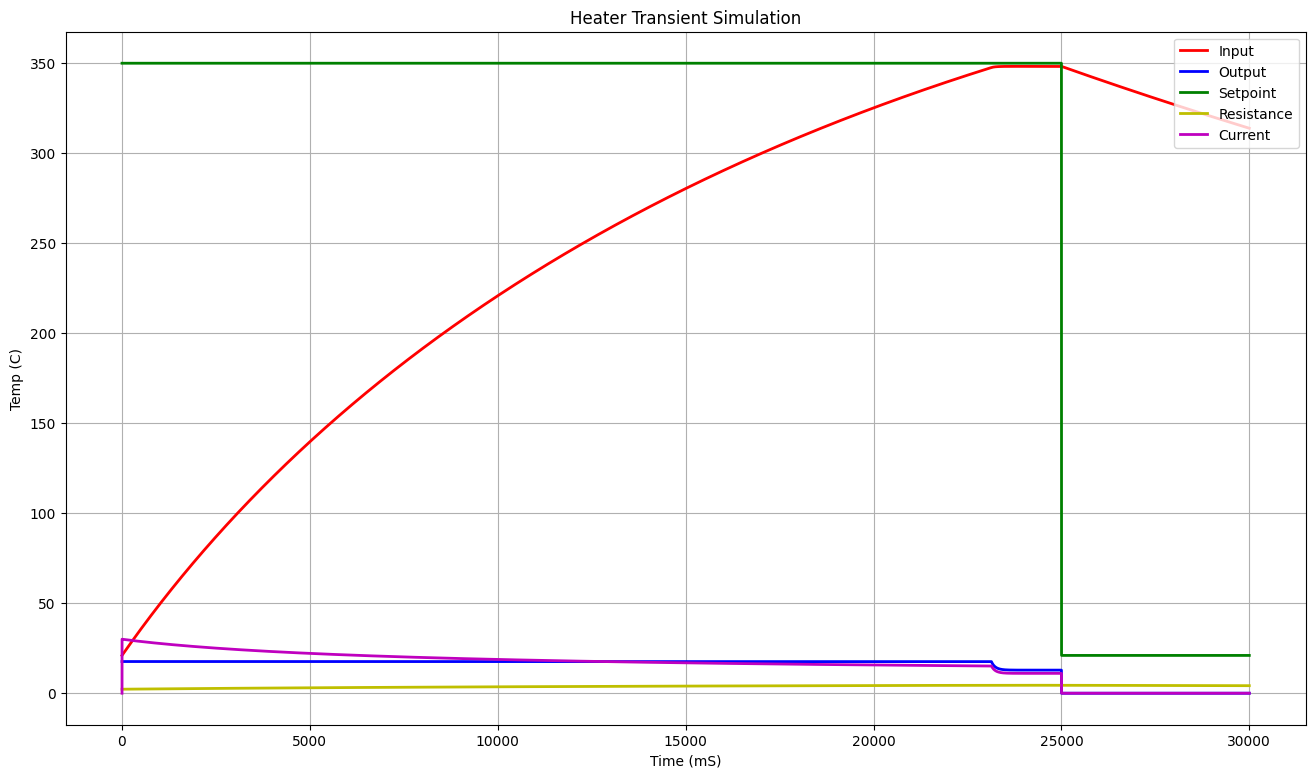

In [10]:
import time
import random
from pid import PID
import numpy as np
import matplotlib.pyplot as plt

# Constants
sigma = 5.67e-8  # Stefan-Boltzmann constant [W/m^2*K^4]
emissivity_h = 0.85 #emisivity of the Aluminum nitride heater
emissivity_s = 0.5 #emisivity of the surroundings
emissivity = 1 / ((1 / emissivity_h) + (1 / emissivity_s) - 1) #emisivity of the system
R_heater_0 = 2.23  # resistance of the heater [Ohm] at T_amb
V = 380.0  # heater voltage [V]
I_limit = 30  # current limit [A]
pwm_max_percent = min(1, I_limit /(V / R_heater_0)) #calculate the maximum drive fraction for the heater based on the ratio of the V/R_heater_0 to the current limit but contrin it to 1
h_n = 20  # natural convection heat transfer coefficient [W/m^2*K]
h_f = 3000  # forced cooling convection heat transfer coefficient [W/m^2*K]
h = h_f
A = .0258 * 2  # surface area for convection heat transfer [m^2] (per heater zone)
Cp = 740.0  # heater material heat capacity [J/kg*K]
Cp_b = 735.79  # block material heat capacity at 0C (linear fit from 20-400C)
Cp_m = 0.2105  # block material heat capacity  at 0C (linear fit from 20-400C)
mass = 0.090  # mass of the heater and coupled mass [kg](per heater zone)
T_amb = 21.0  # ambient temperature for convection [C]
alpha = 0.003  # temperature coefficient of resistance [1/C]

#Define a list of tuples containing the the constants defined above
constants = [
    ('sigma', sigma, 'Stefan-Boltzmann constant [W/m^2*K^4]'),
    ('emissivity_h', emissivity_h, 'emisivity of the Aluminum nitride heater'),
    ('emissivity_s', emissivity_s, 'emisivity of the surroundings'),
    ('emissivity', emissivity, 'emisivity of the system'),
    ('R_heater_0', R_heater_0, 'resistance of the heater [Ohm] at T_amb'),
    ('V', V, 'heater voltage [V]'),
    ('I_limit', I_limit, 'current limit [A]'),
    ('pwm_max_percent', pwm_max_percent, 'maximum drive fraction for the heater as a percentage'),
    ('h_n', h_n, 'natural convection heat transfer coefficient [W/m^2*K]'),
    ('h_f', h_f, 'forced cooling convection heat transfer coefficient [W/m^2*K]'),
    ('h', h, 'heat transfer coefficient [W/m^2*K]'),
    ('A', A, 'surface area for convection heat transfer [m^2] (per heater zone)'),
    ('Cp', Cp, 'heater material heat capacity [J/kg*K]'),
    ('Cp_b', Cp_b, 'block material heat capacity at 0C (linear fit from 20-400C)'),
    ('Cp_m', Cp_m, 'block material heat capacity  at 0C (linear fit from 20-400C)'),
    ('mass', mass, 'mass of the heater and coupled mass [kg](per heater zone)'),
    ('T_amb', T_amb, 'ambient temperature for convection [C]'),
    ('alpha', alpha, 'temperature coefficient of resistance [1/C]')
]

#print titled table of constants
# Print the header
header = "{:<40} {:<20} {:<30}".format("Constant Name", "Value", "Comments")
print(header)
print("=" * len(header))

# Print the constants in a formatted table
for name, value, comment in constants:
    print("{:<40} {:<20} {:<30}".format(name, value, comment))


#print the maximum drive fraction for the heater as a percentage
#print(f'pwm_max_percent = {pwm_max_percent * 100:.2f}%')
#pwm_max_percent = .56  # maximum PWM value

# Control Variables
Input = 21.0 # Initial temperature of the heater [°C]
Output = 0.18 # Initial output of the heater [0-100%]
Setpoint = 350.0 # Desired temperature of the heater [°C]

Kp = 300.0 # Proportional gain 
Ki = 0.0 # Integral gain
Kd = 0.0 # Derivative gain

emulation_dt_ms = 1  # Emulation time step [ms]
total_sim_time = 30000  # Total simulation time [ms]
Power_off_time = 25000 # Time to turn off the heater [ms] (increase to look at the cooling rate)

# Define a list of tuples containing the constant name, value, and comment
control_variables = [
    ('Input', Input, 'Initial temperature of the heater [°C]'),
    ('Output', Output, 'Initial output of the heater [0-100%]'),
    ('Setpoint', Setpoint, 'Desired temperature of the heater [°C]'),
    ('Kp', Kp, 'Proportional gain'),
    ('Ki', Ki, 'Integral gain'),
    ('Kd', Kd, 'Derivative gain'),
    ('emulation_dt_ms', emulation_dt_ms, 'Emulation time step [ms]'),
    ('total_sim_time', total_sim_time, 'Total simulation time [ms]'),
    ('Power_off_time', Power_off_time, 'Time to turn off the heater [ms] (increase to look at the cooling rate)')
]
#print titled table of control variables
print("\n")
# Print the header
header = "{:<40} {:<20} {:<30}".format("Control Variable", "Value", "Comments")
print(header)
print("=" * len(header))

# Print the constants in a formatted table
for name, value, comment in control_variables:
    print("{:<40} {:<20} {:<30}".format(name, value, comment))

# PID controller
pid = PID(Input, Output, Setpoint, Kp, Ki, Kd, PID.DIRECT)

# Main function
def main():
    global emulation_dt_ms, R_heater

    pid.SetMode(PID.AUTOMATIC) # Set PID to automatic mode\
    pid.SetSampleTime(1)  # Sample time in seconds
    pid.SetOutputLimits(0, pwm_max_percent*4095)
    h = h_n # Start with natural convection
    Input_Data = np.array([])
    Output_Data = np.array([])
    Setpoint_Data = np.array([])
    Time_Data = np.array([])
    Resistance_Data = np.array([])
    Current_Data = np.array([])

    while pid.time_counter_ms < total_sim_time:  # Run for 5000 milliseconds (5 seconds)
        if pid.time_counter_ms > Power_off_time:
            pid.Setpoint = T_amb
        P_loss_c = h * A * (pid.Input - T_amb)  # Convection loss here only
        P_loss_r = sigma * A * emissivity * (pid.Input + 273.15) ** 4 # Radiation loss here only
        R_heater = R_heater_0 * (1 + alpha * (pid.Input - T_amb))  # Resistance of the heater
        P_heater = V * V / R_heater * pid.Output / 4095  # Power to the heater
        mCP = mass * (Cp_b + ( Cp_m * pid.Input))  # heat capacity C [J/K], save some computation time
        I_heater = V / R_heater * pid.Output / 4095
        random_noise = 0 # (random.uniform(-2.5, 2.5) / 10) # set to 0 to fall out of a coconut tree

        pid.Input = pid.Input + (((pid.Output / 4095 * P_heater) - P_loss_c - P_loss_r) / mCP * emulation_dt_ms / 1000) + random_noise

        pid.SetSampleTime(emulation_dt_ms)
        pid.Compute() # compute output and increment time counter by emulation_dt_ms

        current_time_ms = pid.time_counter_ms

        Input_Data = np.append(Input_Data, pid.Input)
        Output_Data = np.append(Output_Data, (pid.Output / 4095) * 100)
        Setpoint_Data = np.append(Setpoint_Data, pid.Setpoint)
        Time_Data = np.append(Time_Data, current_time_ms)
        Resistance_Data = np.append(Resistance_Data, R_heater)
        Current_Data = np.append(Current_Data, I_heater)
        #print(f'{current_time_ms/total_sim_time*100:.2f}% complete')
    # create a matplotlib line plot with input, output and setpoint over time
    plt.xlabel('Time (mS)')
    plt.ylabel('Temp (C)')
    plt.title('Heater Transient Simulation')
    plt.grid(True)
    plt.plot(Time_Data, Input_Data, 'r-', label='Input', lw=2)
    plt.plot(Time_Data, Output_Data, 'b-', label='Output', lw=2)
    plt.plot(Time_Data, Setpoint_Data, 'g-', label='Setpoint', lw=2)
    plt.plot(Time_Data, Resistance_Data, 'y-', label='Resistance', lw=2)
    plt.plot(Time_Data, Current_Data, 'm-', label='Current', lw=2)
    # add a legend with legend entries
    plt.legend(loc='upper right')
    #set the plot size in pixels to 16x9 ratio with a width of 1600 pixels
    plt.gcf().set_size_inches(16, 9)

    plt.show()

if __name__ == "__main__":
    main()